In [1]:
'''
Goal in this code block: determine if all of these imports are necessary
'''

import clmm
from clmm import Cosmology
import numpy as np
import math
import matplotlib.pyplot as plt

import sys  #
import h5py #
import matplotlib.pyplot as plt  #
import numpy as np  #T
import random  #
import pandas  #
from scipy import integrate, signal   #T
from scipy.stats import binned_statistic  #T
from scipy.stats import norm   #T
from scipy.special import erf   #T
import astropy   
import astropy.constants as const
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatwCDM
from IPython.display import clear_output
import os
import corner
import emcee
from multiprocessing import Pool
from matplotlib.pyplot import cm
import time as pytime

cosmo = Cosmology(H0=71.0, Omega_dm0=0.2248, Omega_b0=0.2648 - 0.2248, Omega_k0=0.0)

# **CLMM Triaxiality Module - Mass Fitting Tutorial**

Some write up about the layout of the notebook and how all this works. 

## **Section 1**: Mock Catalog Information
Smushing of NFW generated shears

Mention that the halos are always aligned with the major axis, so arbitrary rotation is not necessary. 

Do some mock catalog information generation. 

q value closer to 1 is more spherical, smaller --> more triaxial

## **Section 2**: Estimators
**Background.** The main goal of this is to get the impact of triaxiality on the mass estimation (aka the excess surface density, $\Delta\Sigma$. To make the estimators of this value based on the mock catalogs, the impact of triaxiality is given via a multipole expansion. The monopole term is our spherical NFW halo, and the quadrupole term gives our triaxiality corrections. If you want to read more on this expansion, see (Tae's paper). 

**Implementation.** To make these estimators, a cosmology must first be defined with CLMM Cosmology, as the argument ```cosmo```. This can then be used to call ```cosmo.eval_sigma_crit``` to get $\Sigma_c$ as it is cosmology dependent. 

With the ```make_estimators``` function, you can directly get the $\Delta\Sigma^{mono}$, $\Delta\Sigma^{quad}_{const}$, and $\Delta\Sigma^{quad}_{4\theta}$ by giving the shear and position arguments from the mock halo and return it in radial bins, taking advantage of scipy's ```binned_statistic``` function.

In [3]:
def Delta_Sigma_const(w, gamma1, Sigma_crit) :
	return w * Sigma_crit * gamma1 / w

def Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_4theta_cross(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) - w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_const_cross(w, gamma2, Sigma_crit) :
	return w*Sigma_crit*gamma2 / w

def weights(Sigma_crit, theta, Sigma_shape=0.0001, Sigma_meas=0) :
	## EQUATION 35, 32, 33
	w  = 1 / (Sigma_crit**2 * (Sigma_shape**2 + Sigma_meas**2))
	w1 = np.cos(4*theta)**2 * w
	w2 = np.sin(4*theta)**2 * w
	return w, w1, w2

def make_radial_bins(x, y, Nbins=10) :
	r = np.sqrt(x**2 + y**2)
	#r_bins = np.linspace(np.min(r), np.max(r), Nbins+1)
	rbin_edges = np.logspace(np.log10(0.4), np.log10(2.5), Nbins+1)
	inds = np.digitize(r, rbin_edges, right=True) - 1
	rbin_mean = np.array([np.mean(r[inds==i]) for i in range(Nbins)])
	return r, rbin_edges, rbin_mean, inds

def make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15, method=1):
    sigma_c = cosmo.eval_sigma_crit(0.47,0.8)
    r = np.sqrt((x_arcsec**2 + y_arcsec**2))
    theta = np.arctan2(y_arcsec, x_arcsec)
    #theta = theta - np.pi/2
    r_mpc = r*cosmo.eval_da(z_cl) * np.pi/180.0 * 1/3600#0.00588784182755241#
    
    w, w1, w2 = weights(sigma_c, theta)
    DS4theta = Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, sigma_c)
    DSconst = Delta_Sigma_const(w, gamma1, sigma_c)
    
    bins=15
    if method == 1 :
        ## METHOD 1 ##
        
        r_min = 0.3 #Normally 0.4
        r_max = 2.5
        bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins)
        N_i = []
        for i in np.arange(bins-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)


        result = binned_statistic(r_mpc, gamma1, statistic='mean', bins=bin_edges)
        gamma1_i = result.statistic
        res = binned_statistic(r_mpc, gamma2, statistic='mean', bins=bin_edges)
        gamma2_i = res.statistic
        res = binned_statistic(r_mpc, DS4theta, statistic='mean', bins=bin_edges)
        DS4theta_i_err = binned_statistic(r_mpc, DS4theta, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        DS4theta_i = res.statistic
        res = binned_statistic(r_mpc, DSconst, statistic='mean', bins=bin_edges)
        DSconst_i = res.statistic
        DSconst_i_err = binned_statistic(r_mpc, DSconst, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        #print(bin_edges)
        r_i = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
        #print(r_i)
        
        r_min = 0.3 #Normally 0.4
        r_max = 2.5
        bins_mono=15 #Need more bins always since, if r bin is too thick then averaging doesnt work for shear
        bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins_mono)
        #print(bin_edges)
        N_i = []
        for i in np.arange(bins_mono-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)
        
        r_mono = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
        res = binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='mean', bins=bin_edges)
        gammat_mono = -2*res.statistic
        ds_mono_err = 2*binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)*sigma_c
        ds_mono = gammat_mono*sigma_c
        
    elif method == 2 :
        ## METHOD 2 ## -- DEPRECATED AS WE WANT DIFFERENT NUMBER OF BINS FOR MONOPOLE AND QUADRUPOLE

        Nbins = bins-1
        arcsec_to_Mpc = 0.00588784182755241
        r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)

        ds_mono=[]
        ds_mono_err=[]
        delta_sigmas_4theta = []
        delta_sigmas_const = []
        delta_sigmas_4theta_cross = []
        delta_sigmas_const_cross = []
        delta_sigmas_4theta_err = []
        delta_sigmas_const_err = []
        delta_sigmas_4theta_cross_err = []
        delta_sigmas_const_cross_err = []
        for i in range(Nbins):
            select = (r_inds == i)
            theta_i = theta[select]
            gamma1_i = gamma1[select]
            gamma2_i = gamma2[select]
            w_i, w1_i, w2_i = weights(sigma_c, theta_i)
            DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_c)
            DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_c)
            DSmonoi = gamma1_i*np.cos(2*theta_i)*sigma_c

            ds_mono.append(-2*np.mean(DSmonoi))
            ds_mono_err.append(2*np.std(DSmonoi)/np.sqrt(len(DSmonoi)))
            delta_sigmas_4theta.append(np.mean(DS4thetai))
            delta_sigmas_4theta_err.append(np.std(DS4thetai)/np.sqrt(len(DS4thetai)))
            delta_sigmas_const.append(np.mean(DSconsti))
            delta_sigmas_const_err.append(np.std(DSconsti)/np.sqrt(len(DSconsti)))
            #delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
            #delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

        r_i=np.array(rbin_edges + (rbin_edges[1]-rbin_edges[0]))
        r_mono=r_i
        ds_mono = np.array(ds_mono)
        ds_mono_err = np.array(ds_mono_err)
        DS4theta_i = np.array(delta_sigmas_4theta)
        DS4theta_i_err = np.array(delta_sigmas_4theta_err)
        DSconst_i = np.array(delta_sigmas_const)
        DSconst_i_err = np.array(delta_sigmas_const_err)
        
    # SAFEGUARD AGAINST BINS WITH NANs and 0.0s
    
    ind = np.invert(np.isnan(ds_mono) | np.isnan(ds_mono_err))
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind]
    r_mono = np.sqrt(r_mono[:-1]*r_mono[1:])     [ind]
    ind = (ds_mono!= 0.0) & (ds_mono_err!= 0.0)
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind] 
    r_mono = r_mono[ind] 
    
    ind = np.invert(np.isnan(DS4theta_i) | np.isnan(DS4theta_i_err) | np.isnan(DSconst_i) | np.isnan(DSconst_i_err))
    DS4theta_i = DS4theta_i[ind]
    DS4theta_i_err = DS4theta_i_err[ind]
    DSconst_i = DSconst_i[ind] 
    DSconst_i_err = DSconst_i_err[ind]
    r_i = np.sqrt(r_i[:-1]*r_i[1:])[ind]
    
    return ds_mono,np.abs(ds_mono_err),r_mono,DS4theta_i,np.abs(DS4theta_i_err),DSconst_i,np.abs(DSconst_i_err),r_i

In [17]:
## implementing it here
dir_loc = "/global/homes/d/dericj/CLMM/examples/triaxiality/Elliptical_lenses_data/catalog_horizontal_rescale_q0.5/"


## formatting the parameters properly
gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

## using make_estimators to calculate delta sigmas (ds)
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err, ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, 
                                                x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1034654/3148205022.py:1: SyntaxWarning: invalid escape sequence '\D'
  plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, marker='.', ls='None', color='black', label='$\Delta\Sigma^{mono}$')
/tmp/ipykernel_1034654/3148205022.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)


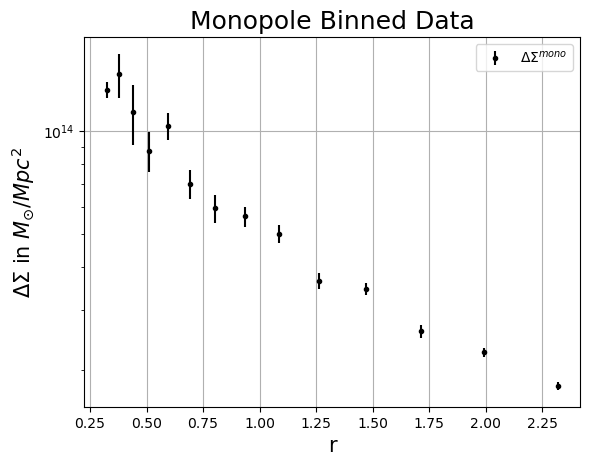

In [23]:
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, marker='.', ls='None', color='black', label='$\Delta\Sigma^{mono}$')
plt.xlabel('r', fontsize=15)
plt.title('Monopole Binned Data',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1034654/1883816108.py:1: SyntaxWarning: invalid escape sequence '\D'
  plt.errorbar(r_quad, ds_quad_4theta, yerr=ds_quad_4theta_err, ls='None', marker='o', color='blue', label='$\Delta\Sigma^{quad}_{4\theta}$')
/tmp/ipykernel_1034654/1883816108.py:2: SyntaxWarning: invalid escape sequence '\D'
  plt.errorbar(r_quad, ds_quad_const, yerr=ds_quad_const_err, ls='None', marker='s', color='orange', label='$\Delta\Sigma^{quad}_{const}$')
/tmp/ipykernel_1034654/1883816108.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)


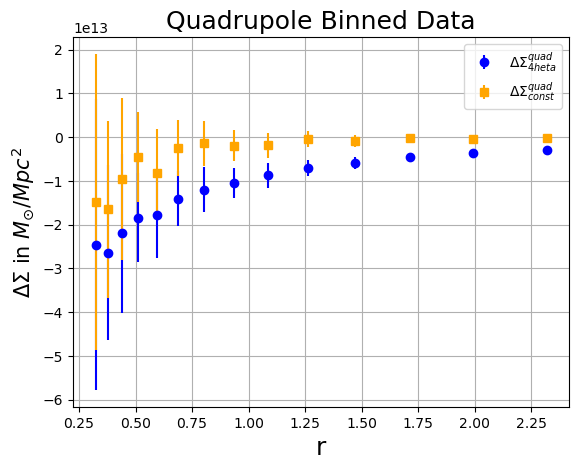

In [26]:
plt.errorbar(r_quad, ds_quad_4theta, yerr=ds_quad_4theta_err, ls='None', marker='o', color='blue', label='$\Delta\Sigma^{quad}_{4\theta}$')
plt.errorbar(r_quad, ds_quad_const, yerr=ds_quad_const_err, ls='None', marker='s', color='orange', label='$\Delta\Sigma^{quad}_{const}$')

plt.xlabel('r', fontsize=18)
plt.title('Quadrupole Binned Data',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.legend()
plt.grid()
plt.show()

## **Section 4**: MCMC & Fitting
How MCMC and the fitting parameters works in this to get the results we want

**Background.** The goal of this is to get an estimate for the 3 parameters being looked at: $M_{200c}$, $c_{200c}$, and $e$, which is the ellipticity. To do so, the estimated $\Delta\Sigma$ values are used as the prep data for a Markov Chain Monte Carlo (MCMC) walk through the parameter space. 

**Method.** This process uses the ```emcee``` package to run the MCMC on the three parameter space and output the necessary plots. 